# Generative Adversarial Nets

<img src="https://github.com/drmoon-1st/Paper-Implementation/blob/main/Generative%20Adversarial%20Nets/img/screenshot_230111(7).png?raw=true" width=800 height=600>

## Features

### Adversarial nets

<img src='https://github.com/drmoon-1st/Paper-Implementation/blob/main/Generative%20Adversarial%20Nets/img/screenshot_23110_(1).png?raw=true' width=600 height=150>

> * $x$ : Data
> * $p_g$ : Generator's distribution
> * $p_z(z)$ : Prior on input noise variables.
> * $G(z;\theta_g)$ : Data space where $G$ is a differentiable function represented by a multilayer perceptron with parameters $\theta_g$.
> * $D(x;\theta_d)$ : Second multilayer perceptron that outputs a single scalar.
> * $D(x)$ : Represents the probability that $x$ came from the data rather than $p_g$.
> * Train $D$ to maximize the problbility of assigning the correct label to both training examples and samples from $G$.
> * Train $G$ to minimize $log(1-D(G(z)))$.
> * $D$ and $G$ play the following two-player minimax game with value function $V(G, D)$.

<img src='https://github.com/drmoon-1st/Paper-Implementation/blob/main/Generative%20Adversarial%20Nets/img/screenshot_220110(2).png?raw=true' width=900 height=500>

* The training criterion allows one to recover the data generation distribution as $G$ and $D$ are given enough capacity, i.e., in the non-oarametric limit.
* Alternated between $k$ steps of optimizing $D$ and one step of optimizing $G$.
* After several steps of training, if $G$ and $D$ have enough capacity, they will reach a point at which both cannot improve becaues $p_g = p_{data}$.

### Theoretical  Results

<img src="https://github.com/drmoon-1st/Paper-Implementation/blob/main/Generative%20Adversarial%20Nets/img/screenshot_230111(1).png?raw=true" width=600 height=150>

> * Sample minibatch of $m$ noise samples {$z^{(1)}, z^{(2)},...,z^{(m)}$} from noise prior p_g(z).
> * Sample minibatch of $m$ examples {$z^{(1)}, z^{(2)},...,z^{(m)}$} from data generating distribution $p_{data}(x)$

<img src="https://github.com/drmoon-1st/Paper-Implementation/blob/main/Generative%20Adversarial%20Nets/img/screenshot_230111(2).png?raw=true" width=300 height=150>

<img src="https://github.com/drmoon-1st/Paper-Implementation/blob/main/Generative%20Adversarial%20Nets/img/screenshot_230111(3).png?raw=true" width=600 height>

<img src="https://github.com/drmoon-1st/Paper-Implementation/blob/main/Generative%20Adversarial%20Nets/img/screenshot_230111(4).png?raw=true" width=600 height=150>

<img src="https://github.com/drmoon-1st/Paper-Implementation/blob/main/Generative%20Adversarial%20Nets/img/screenshot_230111(5).png?raw=true" width=600 height=150>

<img src="https://github.com/drmoon-1st/Paper-Implementation/blob/main/Generative%20Adversarial%20Nets/img/screenshot_230111(6).png?raw=true" width=350 height=150>

## Other Concept

### Parametric model and Non-parametric model

* Parametric model : The model has a fixed number of parameters.
    * Fast and easy to understand model.
    * Low flexibility
* Non-parametric model : The number of parameters grow with the amount of training data.
    * Flexible
    * Slow and hard to understand model.

## Practice Code

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import mnist
import numpy as np

import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

In [3]:
def sampling(args: tuple):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

2023-01-19 17:58:59.877422: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-19 17:58:59.898748: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-19 17:58:59.899020: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-19 17:58:59.900866: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

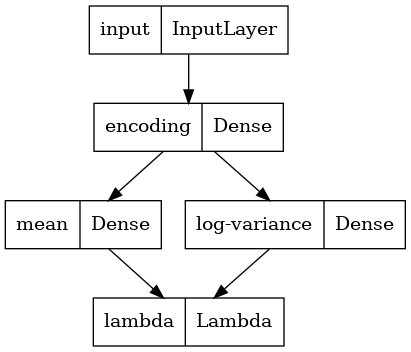

In [4]:
x = Input(shape=(original_dim,), name="input")
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
z_mean = Dense(latent_dim, name="mean")(h)
z_log_var = Dense(latent_dim, name="log-variance")(h)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")
# encoder.summary()
plot_model(encoder)

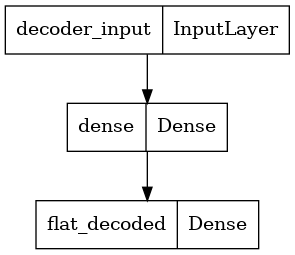

In [5]:
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
decoder_h = Dense(intermediate_dim, activation='relu')(input_decoder)
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)
decoder = Model(input_decoder, x_decoded, name="decoder")
# decoder.summary()
plot_model(decoder)

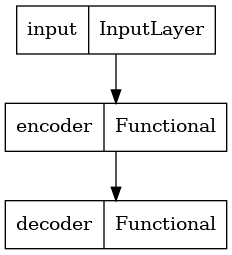

In [6]:
output_combined = decoder(encoder(x)[2])
vae = Model(x, output_combined)
# vae.summary()
plot_model(vae)

In [7]:
kl_loss = -0.5 * K.sum(1 + z_log_var - K.exp(z_log_var) - K.square(z_mean), axis=-1)
vae.add_loss(K.mean(kl_loss) / 784.)
vae.compile(optimizer='rmsprop', loss='binary_crossentropy')
vae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          201988      ['input[0][0]']                  
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 decoder (Functional)           (None, 784)          202256      ['encoder[0][2]']                
                                                                                              

In [9]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [10]:
x_train.shape

(60000, 784)

In [11]:
vae.fit(x_train, x_train, shuffle=True, epochs=epochs, batch_size=batch_size)

Epoch 1/50
 77/600 [==>...........................] - ETA: 1s - loss: 0.3273

2023-01-19 17:59:11.872559: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


600/600 [==============================] - 2s 2ms/step - loss: 0.2445
Epoch 2/50
600/600 [==============================] - 1s 2ms/step - loss: 0.2167
Epoch 3/50
600/600 [==============================] - 1s 2ms/step - loss: 0.2120
Epoch 4/50
600/600 [==============================] - 1s 2ms/step - loss: 0.2092
Epoch 5/50
600/600 [==============================] - 1s 2ms/step - loss: 0.2069
Epoch 6/50
600/600 [==============================] - 1s 2ms/step - loss: 0.2049
Epoch 7/50
600/600 [==============================] - 1s 2ms/step - loss: 0.2034
Epoch 8/50
600/600 [==============================] - 1s 2ms/step - loss: 0.2023
Epoch 9/50
600/600 [==============================] - 1s 2ms/step - loss: 0.2014
Epoch 10/50
600/600 [==============================] - 1s 2ms/step - loss: 0.2007
Epoch 11/50
600/600 [==============================] - 1s 2ms/step - loss: 0.2000
Epoch 12/50
600/600 [==============================] - 1s 2ms/step - loss: 0.1994
Epoch 13/50
600/600 [===============

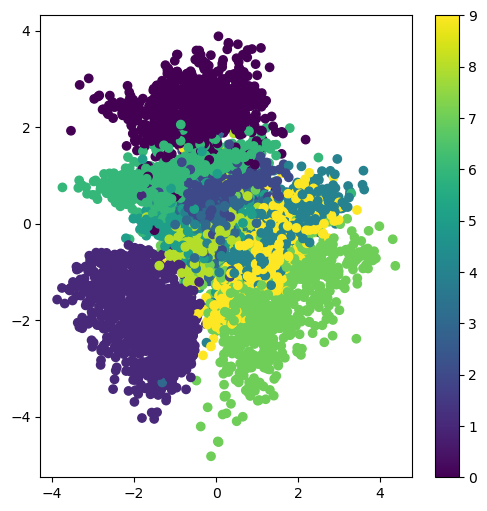

In [11]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='viridis')
plt.colorbar()

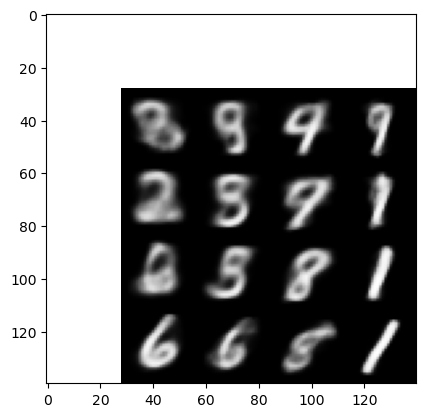

In [13]:
n = 5
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(-0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(-0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_smaple = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_smaple)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
              j * digit_size: (j + 1) * digit_size] = digit
plt.figure()
plt.imshow(figure, cmap='Greys_r')

In [ ]:
celeb_img_path = '/home/khmoon/python/datasets/celeb_face_img/img_align_celeba'

In [ ]:
from PIL import Image
Image.open("000001.jpg").size

In [ ]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [35]:
batch_size = 100
original_dim = 178 * 218
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

x = Input(shape=(original_dim,), name="input")
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
z_mean = Dense(latent_dim, name="mean")(h)
z_log_var = Dense(latent_dim, name="log-variance")(h)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")

input_decoder = Input(shape=(latent_dim,), name="decoder_input")
decoder_h = Dense(intermediate_dim, activation='relu')(input_decoder)
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)
decoder = Model(input_decoder, x_decoded, name="decoder")

output_combined = decoder(encoder(x)[2])
vae = Model(x, output_combined)

kl_loss = -0.5 * K.sum(1 + z_log_var - K.exp(z_log_var) - K.square(z_mean), axis=-1)
vae.add_loss(K.mean(kl_loss) / 38804.)
vae.compile(optimizer='rmsprop', loss='binary_crossentropy')

import glob
images = glob.glob('/home/khmoon/python/datasets/celeb_face_img/img_align_celeba/*.jpg')

x_train = []

for image in images[:10000]:
    x_train.append(rgb2gray(np.array(Image.open(image))))

x_train = np.array(x_train)
x_train.shape

x_train = x_train / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_train.shape

vae.fit(x_train, x_train, shuffle=True, epochs=200, batch_size=50, verbose=0)

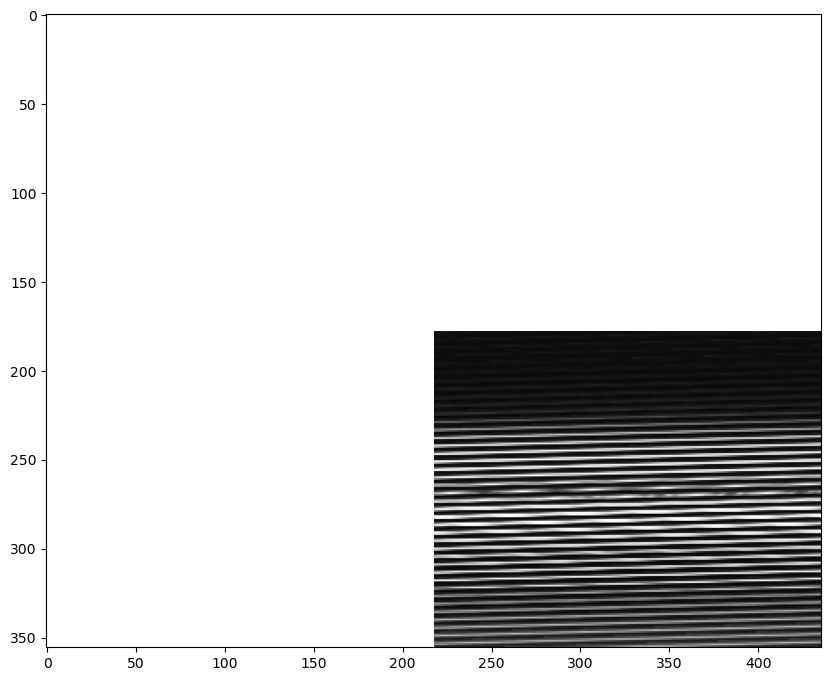

In [37]:
n = 2
digit_size = 178
figure = np.zeros(((digit_size) * n, (digit_size+40) * n))
grid_x = norm.ppf(np.linspace(-0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(-0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_smaple = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_smaple)
        digit = x_decoded[0].reshape(digit_size, (digit_size+40))
        figure[i * (digit_size): (i + 1) * (digit_size),
              j * (digit_size+40): (j + 1) * (digit_size+40)] = digit
plt.figure(figsize=(10,10))
plt.imshow(figure, cmap='Greys_r')

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, Input
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [14]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

z_dim = 100

In [15]:
def build_generator(img_shape, z_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=z_dim))
    model.add(Dense(256, activation='swish'))
    model.add(Dense(256, activation='swish'))
    model.add(Dense(256, activation='swish'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(28 * 28 * 1, activation='tanh'))
    model.add(Reshape(img_shape))
    return model

def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))
    return model

def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [16]:
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

generator = build_generator(img_shape, z_dim)

discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [17]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    
    (x_train, _), (_, _) = mnist.load_data()
    
    x_train = x_train / 127.5 - 1.0
    x_train = np.expand_dims(x_train, axis=3)
    
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iterations):
        
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs = x_train[idx]
        
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        g_loss = gan.train_on_batch(z, real)
        
        if (iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)
            
            print("%d [D 손실: %f, 정확도: %.2f%%] [G 손실: %f]" % (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            
            sample_images(generator)

In [33]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    
    gen_imgs = generator.predict(z)
    
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    fig, ax = plt.subplots(image_grid_rows,
                          image_grid_columns,
                          figsize=(4, 4),
                          sharey=True,
                          sharex=True)
    
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            ax[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            ax[i, j].axis('off')
            cnt += 1

1000 [D 손실: 0.000354, 정확도: 100.00%] [G 손실: 8.277849]
2000 [D 손실: 0.000014, 정확도: 100.00%] [G 손실: 11.464528]
3000 [D 손실: 0.000005, 정확도: 100.00%] [G 손실: 12.699604]
4000 [D 손실: 0.000003, 정확도: 100.00%] [G 손실: 13.777969]
5000 [D 손실: 1.062380, 정확도: 69.92%] [G 손실: 22.253281]
6000 [D 손실: 0.000007, 정확도: 100.00%] [G 손실: 11.259223]
7000 [D 손실: 0.000001, 정확도: 100.00%] [G 손실: 12.988662]
8000 [D 손실: 0.000178, 정확도: 100.00%] [G 손실: 8.641048]
9000 [D 손실: 0.000009, 정확도: 100.00%] [G 손실: 10.967581]
10000 [D 손실: 0.000002, 정확도: 100.00%] [G 손실: 12.831861]
11000 [D 손실: 0.000006, 정확도: 100.00%] [G 손실: 13.529089]
12000 [D 손실: 0.000000, 정확도: 100.00%] [G 손실: 14.874390]
13000 [D 손실: 0.000000, 정확도: 100.00%] [G 손실: 16.064182]
14000 [D 손실: 0.000000, 정확도: 100.00%] [G 손실: 16.766130]
15000 [D 손실: 0.000000, 정확도: 100.00%] [G 손실: 18.072193]
16000 [D 손실: 0.000000, 정확도: 100.00%] [G 손실: 18.866930]
17000 [D 손실: 0.000000, 정확도: 100.00%] [G 손실: 20.158665]
18000 [D 손실: 0.000000, 정확도: 100.00%] [G 손실: 21.023396]
19000 [D 손실: 0.000000,

/tmp/ipykernel_2117181/578053147.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(image_grid_rows,


22000 [D 손실: 0.000000, 정확도: 100.00%] [G 손실: 23.731266]
23000 [D 손실: 0.000005, 정확도: 100.00%] [G 손실: 11.502637]
24000 [D 손실: 0.000001, 정확도: 100.00%] [G 손실: 13.384356]
25000 [D 손실: 0.000000, 정확도: 100.00%] [G 손실: 22.500143]
26000 [D 손실: 0.000000, 정확도: 100.00%] [G 손실: 16.657780]
27000 [D 손실: 0.000000, 정확도: 100.00%] [G 손실: 15.540293]
28000 [D 손실: 0.000019, 정확도: 100.00%] [G 손실: 10.770218]
29000 [D 손실: 0.000008, 정확도: 100.00%] [G 손실: 11.055043]
30000 [D 손실: 0.000000, 정확도: 100.00%] [G 손실: 14.539905]


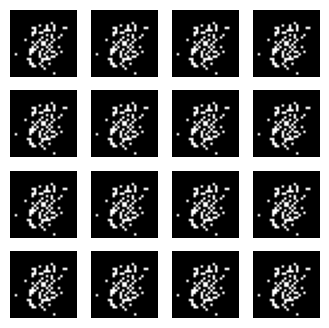

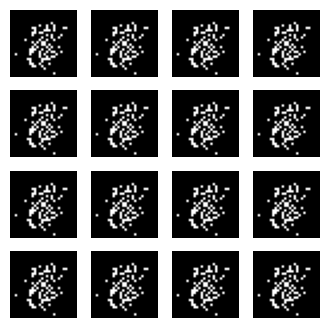

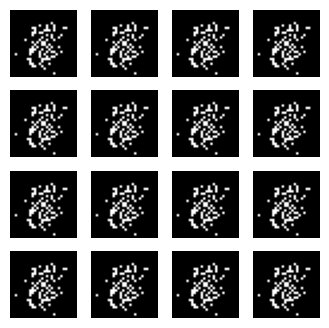

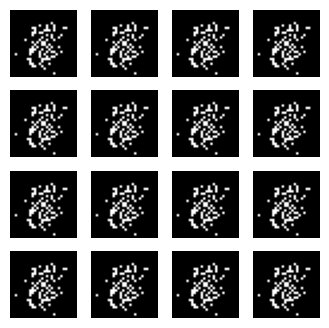

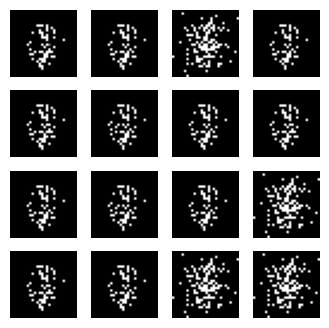

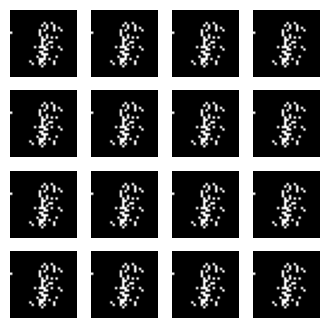

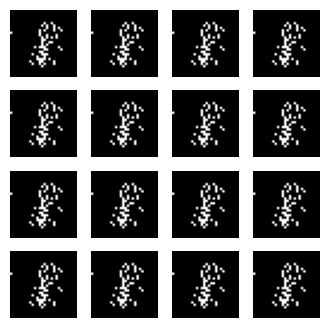

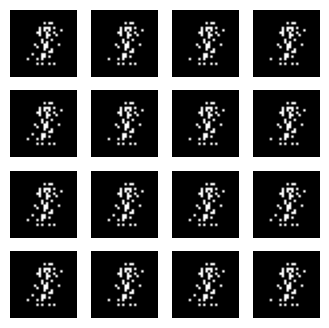

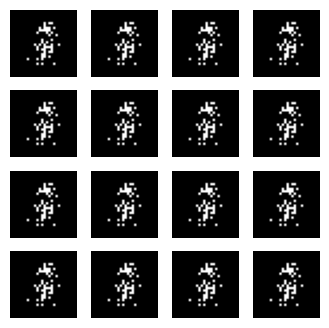

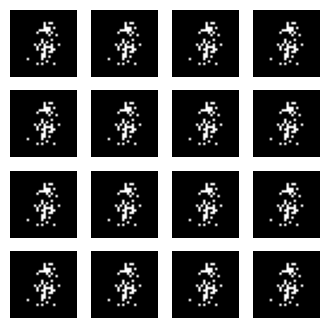

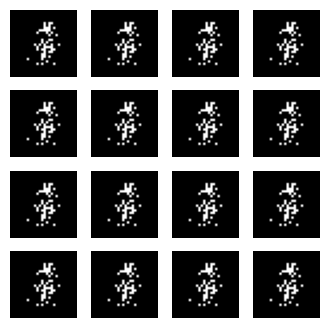

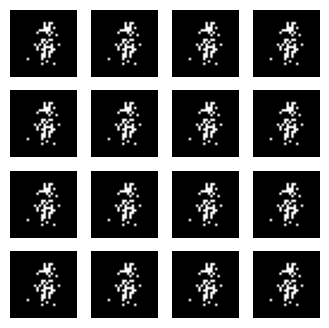

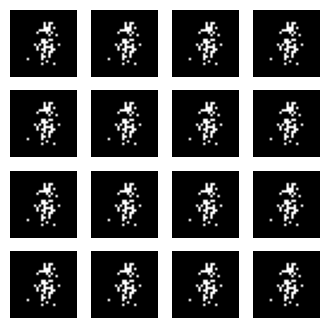

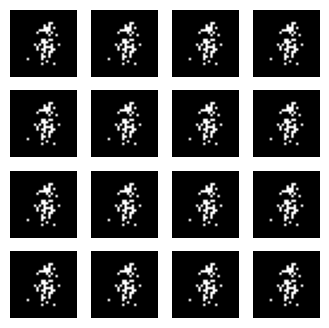

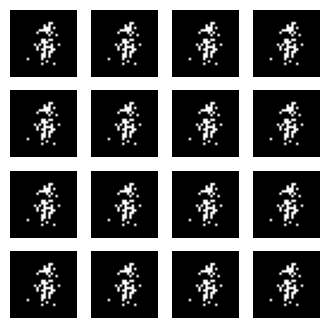

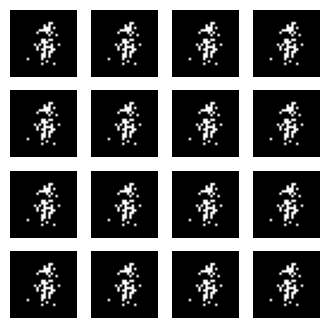

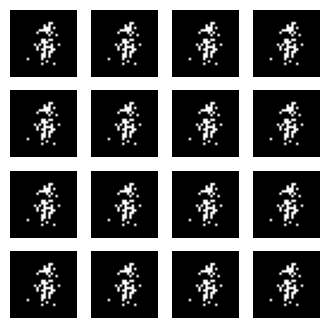

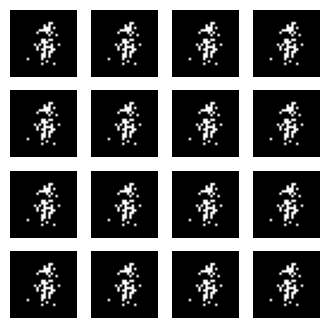

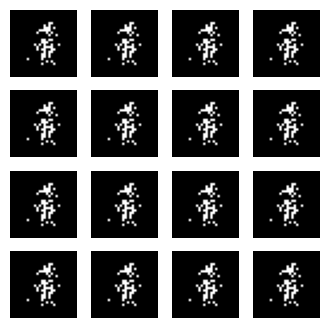

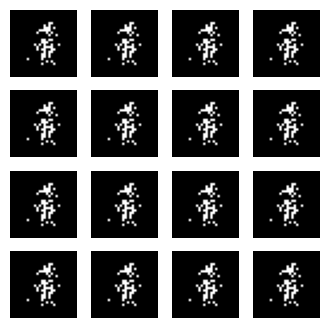

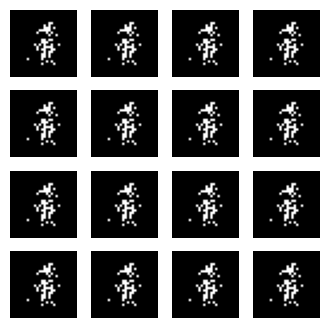

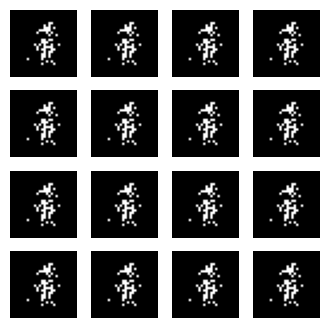

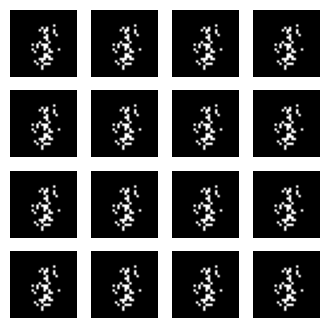

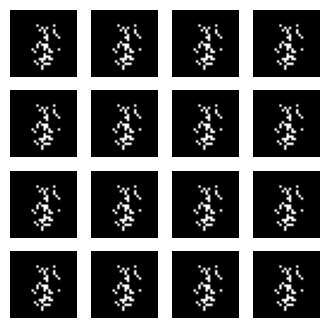

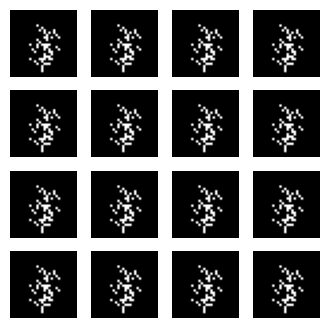

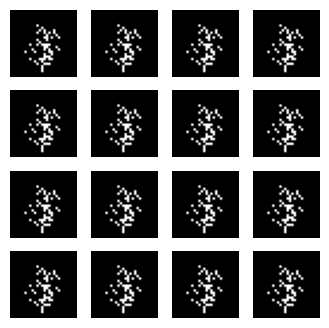

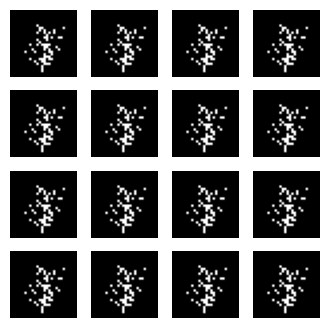

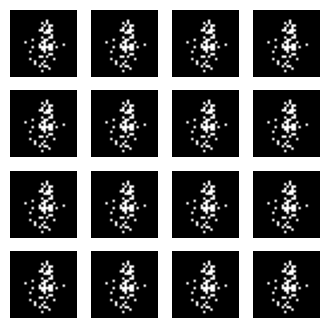

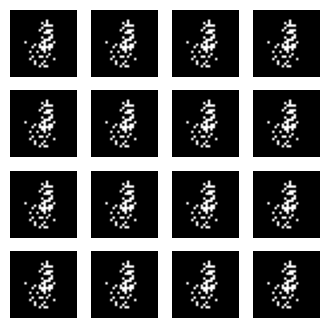

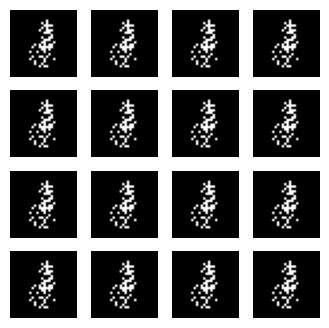

In [19]:
iterations = 30000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)

1000 [D 손실: 0.6441062092781067, 정확도: 63.67] [G 손실: 0.9173545241355896]
2000 [D 손실: 0.6320273578166962, 정확도: 64.06] [G 손실: 0.9615343809127808]
3000 [D 손실: 0.6875348389148712, 정확도: 57.42] [G 손실: 0.8155656456947327]
4000 [D 손실: 0.5976417660713196, 정확도: 69.14] [G 손실: 0.9474776983261108]
5000 [D 손실: 0.6513221859931946, 정확도: 57.81] [G 손실: 0.8670274019241333]


2023-01-21 18:04:34.313421: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2023-01-21 18:04:45.046187: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


6000 [D 손실: 0.6565949320793152, 정확도: 62.50] [G 손실: 0.8750450611114502]
7000 [D 손실: 0.6878974437713623, 정확도: 60.55] [G 손실: 0.7627054452896118]


2023-01-21 18:06:43.781553: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


8000 [D 손실: 0.6833336353302002, 정확도: 56.64] [G 손실: 0.7767658233642578]
9000 [D 손실: 0.6825925409793854, 정확도: 55.08] [G 손실: 0.784401535987854]


2023-01-21 18:09:24.381614: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


10000 [D 손실: 0.6664376556873322, 정확도: 59.38] [G 손실: 0.7905855178833008]
11000 [D 손실: 0.700840026140213, 정확도: 56.64] [G 손실: 0.8175864219665527]


2023-01-21 18:10:33.927059: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2023-01-21 18:10:34.649590: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2023-01-21 18:11:06.023751: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2023-01-21 18:11:20.219265: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


12000 [D 손실: 0.7078520655632019, 정확도: 55.86] [G 손실: 0.7628007531166077]
13000 [D 손실: 0.6655645668506622, 정확도: 55.08] [G 손실: 0.7956283092498779]
14000 [D 손실: 0.6976980268955231, 정확도: 58.20] [G 손실: 0.7967574596405029]
15000 [D 손실: 0.6709058880805969, 정확도: 58.20] [G 손실: 0.8045569062232971]
16000 [D 손실: 0.6654160916805267, 정확도: 60.16] [G 손실: 0.9032642245292664]
17000 [D 손실: 0.6489003598690033, 정확도: 64.84] [G 손실: 0.8864586353302002]
18000 [D 손실: 0.673417329788208, 정확도: 61.33] [G 손실: 0.7693040370941162]
19000 [D 손실: 0.6697476506233215, 정확도: 58.20] [G 손실: 0.7530626058578491]
20000 [D 손실: 0.6837798655033112, 정확도: 55.86] [G 손실: 0.8025597333908081]


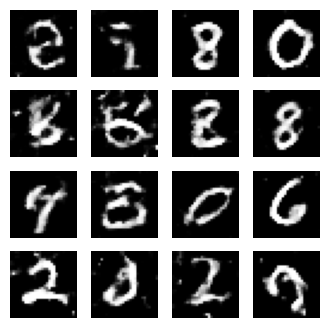

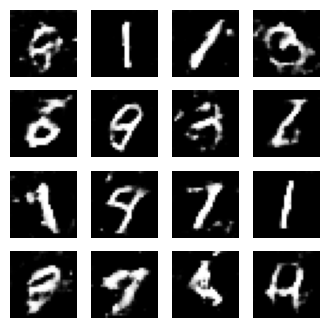

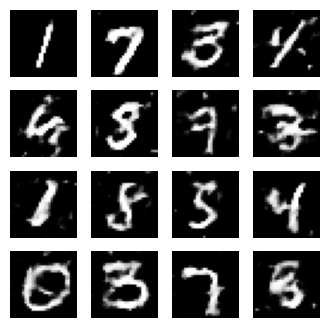

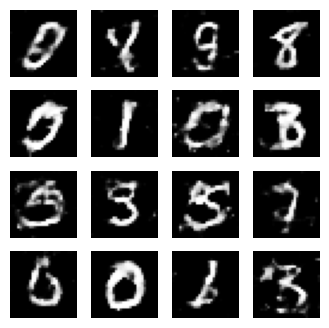

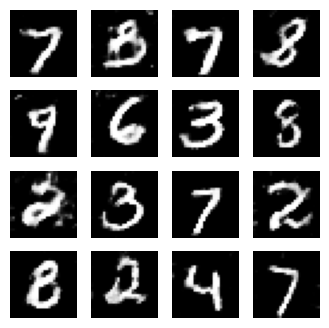

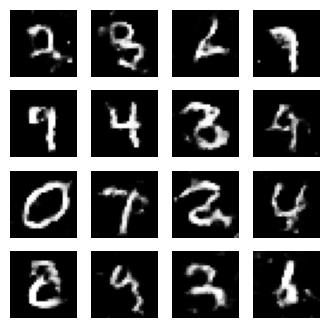

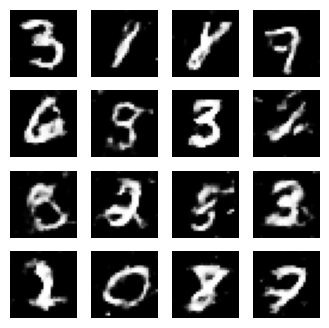

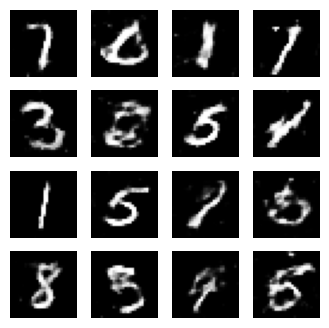

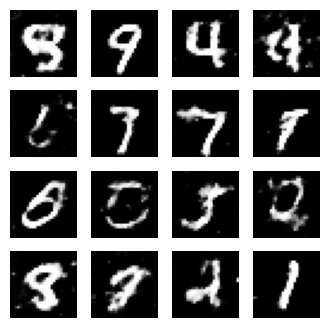

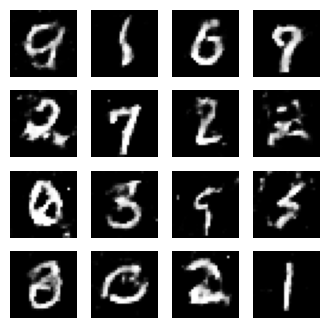

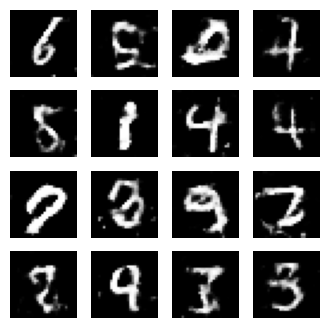

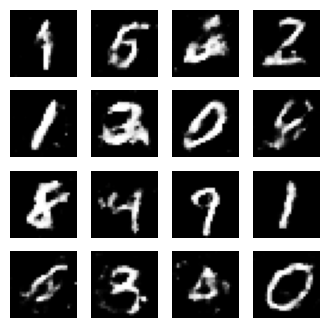

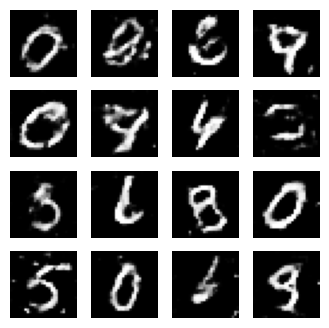

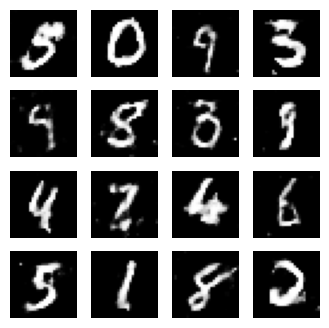

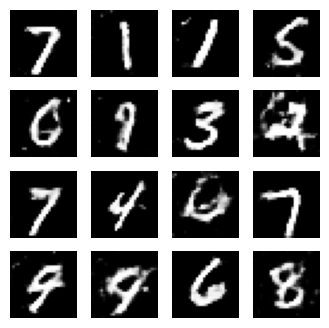

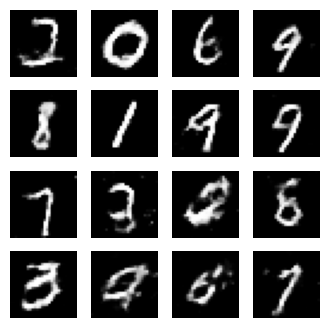

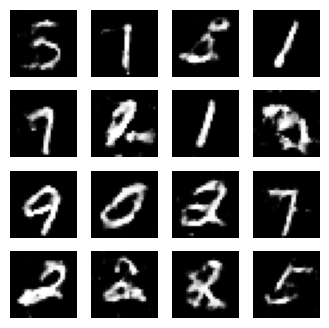

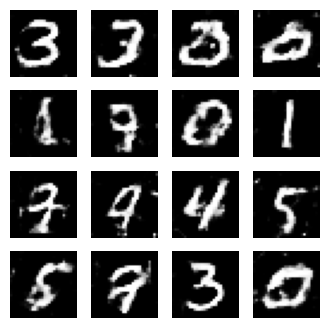

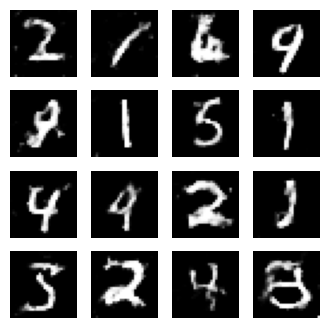

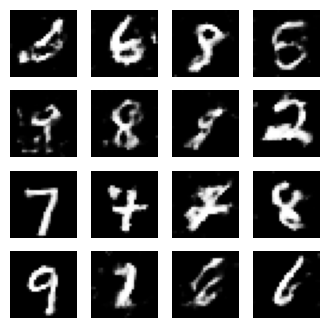

In [73]:
iterations = 20000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)

In [23]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [24]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

z_dim = 100

In [27]:
def build_generator(z_dim):
    model = Sequential()
    
    model.add(Dense(256 * 7 *7 , input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))
    
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    
    model.add(BatchNormalization())
    
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    
    model.add(BatchNormalization())
    
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
    
    model.add(Activation('tanh'))

    return model

In [28]:
build_generator(z_dim).summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 12544)             1266944   
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      295040    
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 128)      512       
 ormalization)                                                   
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 14, 14, 64)     

In [29]:
def build_descriminator(img_shape):
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding='same', activation='swish'))
    
    model.add(Conv2D(64, kernel_size=3, strdes=2, padding='same', activation='swish'))
    
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same', activation='swish'))
    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [69]:
def build_gan(generator, discriminator):
    model = Sequential()
    
    model.add(generator)
    model.add(discriminator)
    
    return model

In [70]:
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                     optimizer=Adam(),
                     metrics=['accuracy'])

generator = build_generator(z_dim)

discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [71]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    (x_train, _), (_, _) = mnist.load_data()
    
    x_train = x_train / 127.5 - 1.0
    x_train = np.expand_dims(x_train, axis=3)
    
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iterations):
        
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs = x_train[idx]
        
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        g_loss = gan.train_on_batch(z, real)
        
        if (iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)
            
            print(f'{iteration + 1} [D 손실: {d_loss}, 정확도: {100 * accuracy:.2f}] [G 손실: {g_loss}]')
            
            sample_images(generator)

1000 [D 손실: 0.48753684759140015, 정확도: 76.17] [G 손실: 1.903944969177246]
2000 [D 손실: 0.42182086408138275, 정확도: 82.42] [G 손실: 1.5371723175048828]
3000 [D 손실: 0.41494959592819214, 정확도: 80.47] [G 손실: 1.6013696193695068]
4000 [D 손실: 0.6580492854118347, 정확도: 66.02] [G 손실: 1.115799903869629]
5000 [D 손실: 0.6893600523471832, 정확도: 62.89] [G 손실: 1.1228915452957153]
6000 [D 손실: 0.681850403547287, 정확도: 63.67] [G 손실: 1.012343168258667]
7000 [D 손실: 0.45710161328315735, 정확도: 80.47] [G 손실: 1.6930629014968872]
8000 [D 손실: 0.5438995659351349, 정확도: 74.22] [G 손실: 1.2250558137893677]
9000 [D 손실: 0.6568580269813538, 정확도: 63.28] [G 손실: 1.048523187637329]
10000 [D 손실: 0.5518234968185425, 정확도: 76.17] [G 손실: 1.2664018869400024]
11000 [D 손실: 0.6132064163684845, 정확도: 66.80] [G 손실: 0.9939815998077393]
12000 [D 손실: 0.6026991307735443, 정확도: 67.58] [G 손실: 1.0387457609176636]
13000 [D 손실: 0.6687444746494293, 정확도: 62.50] [G 손실: 0.9604187607765198]
14000 [D 손실: 0.567459225654602, 정확도: 73.05] [G 손실: 1.0271809101104736]
150

2023-01-21 17:43:12.505315: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


18000 [D 손실: 0.6843588948249817, 정확도: 60.55] [G 손실: 0.8954200148582458]
19000 [D 손실: 0.6556215584278107, 정확도: 63.28] [G 손실: 0.901174783706665]
20000 [D 손실: 0.6441831290721893, 정확도: 58.98] [G 손실: 0.8485088348388672]


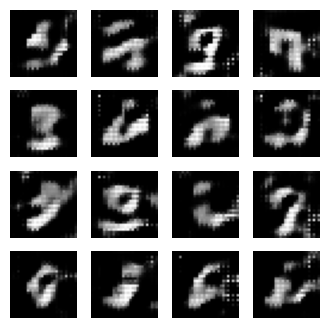

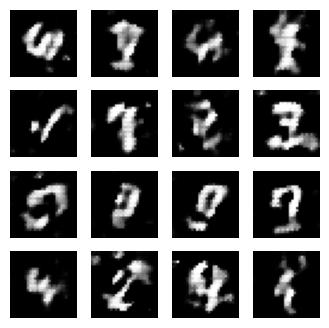

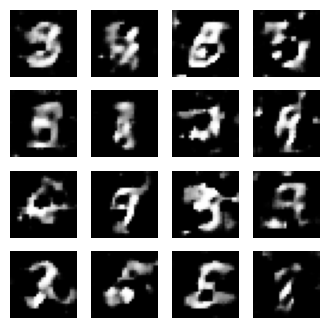

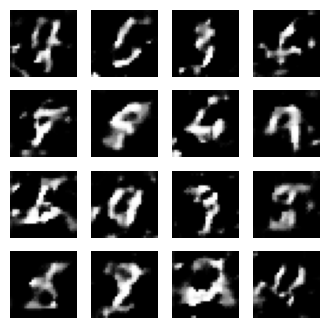

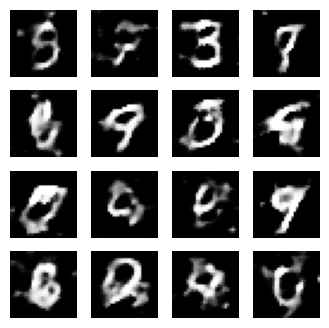

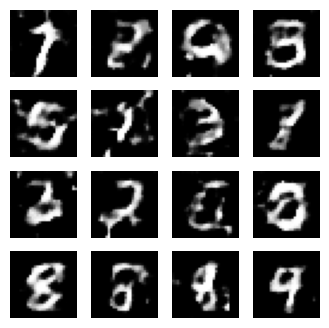

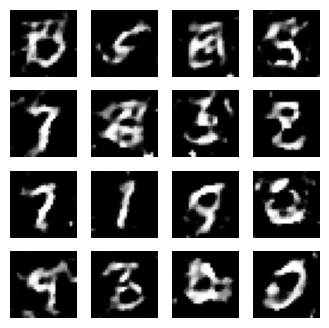

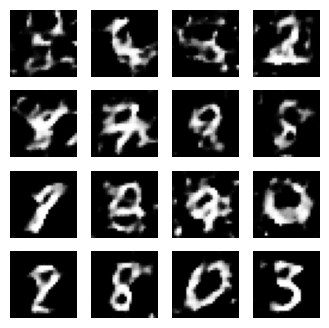

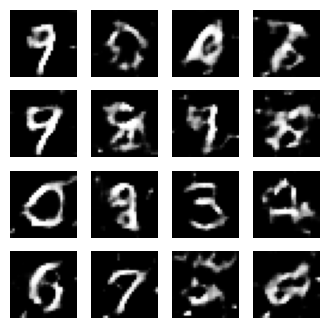

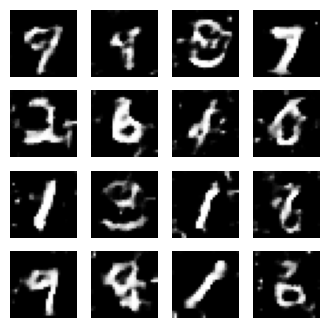

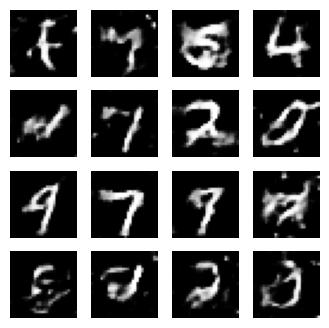

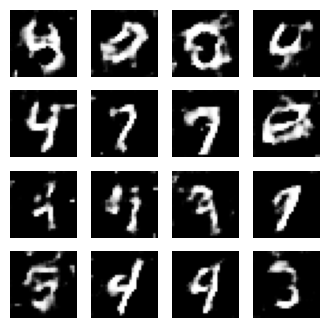

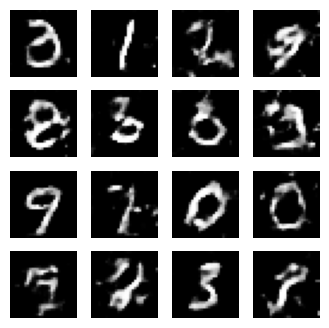

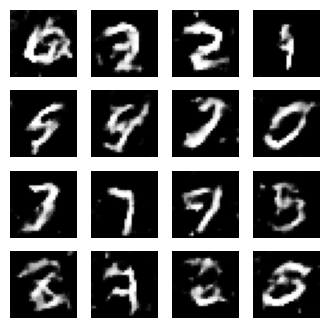

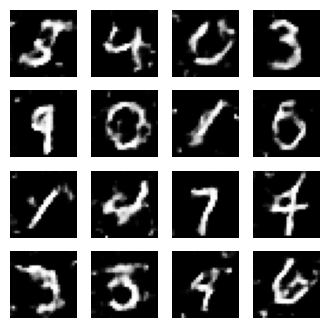

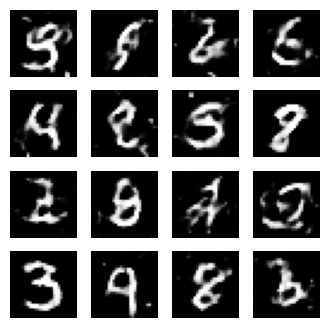

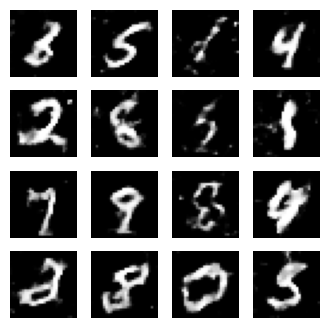

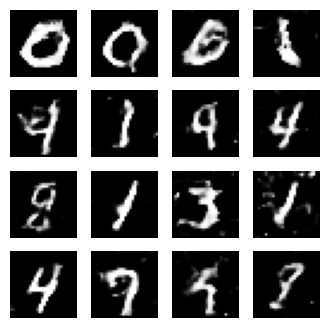

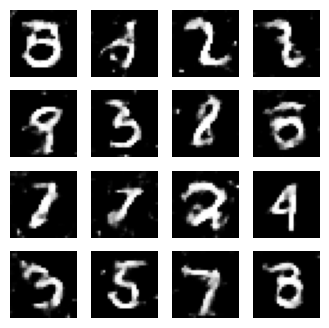

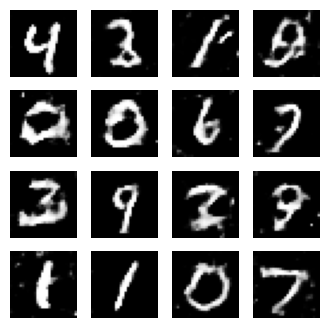

In [72]:
iterations = 20000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)

## Reference

Paper : https://arxiv.org/pdf/1406.2661v1.pdf